In [ ]:
#!pip install qiskit-aqua
#!pip install qiskit
#!pip install qiskit_optimization

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import numpy as np
import pandas as pd
import time
import math
import itertools

import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from qiskit import Aer
from qiskit_optimization.applications import Maxcut
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [22]:
import os

def create_dir(path, log=False):
    if not os.path.exists(path):
        if log:
            print('The directory', path, 'does not exist and will be created')
        os.makedirs(path)
    else:
        if log:
            print('The directory', path, ' already exists')

### Brute force solution

In [4]:
def solve_brute_force(n_agents, induced_subgraph_game):
  G=nx.Graph()
  G.add_nodes_from(np.arange(0,n_agents,1))
  elist = [tuple((int(x)-1 for x in key.split(',')))+tuple([induced_subgraph_game[key]*-1]) for key in induced_subgraph_game]
  G.add_weighted_edges_from(elist)
  w = [[G.get_edge_data(i,j,default = {'weight': 0})['weight']  for j in range(n_agents)] for i in range(n_agents)]

  x = [int(t) for t in reversed(list(bin(0)[2:].zfill(n_agents)))]
  cost = [[w[i][j]*x[i]*(1-x[j]) for j in range(n_agents)] for i in range(n_agents)]
  best_cost_brute = sum([sum(i) for i in cost])
  xbest_brute = x

  for b in range(1, 2**(n_agents-1)):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n_agents)))]
    cost = [[w[i][j]*x[i]*(1-x[j]) for j in range(n_agents)] for i in range(n_agents)]
    cost = sum([sum(i) for i in cost])
    if cost > best_cost_brute:
      best_cost_brute = cost
      xbest_brute = x
  return np.array(xbest_brute), -best_cost_brute

### Qiskit exact solution using NumpyEigensolver (Cassical)

In [5]:
def solve_qiskit_classical_eigensolver(n_agents, induced_subgraph_game):
  G=nx.Graph()
  G.add_nodes_from(np.arange(0,n_agents,1))
  elist = [tuple((int(x)-1 for x in key.split(',')))+tuple([induced_subgraph_game[key]*-1]) for key in induced_subgraph_game]
  G.add_weighted_edges_from(elist)
  w = [[G.get_edge_data(i,j,default = {'weight': 0})['weight']  for j in range(n_agents)] for i in range(n_agents)]
  w = np.array([np.array(row) for row in w])
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  qubitOp, offset = qp.to_ising()
  exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
  result = exact.solve(qp)
  return result.x, -result.fval

### Qiskit heuristic solution using QAOA

In [6]:
def solve_qiskit_QAOA(n_agents, induced_subgraph_game, reps = 1, simulator = "aer_simulator_statevector", shots=1000, seed_simulator=123, seed_transpiler=123):
  backend=Aer.get_backend(simulator)
  qins = QuantumInstance(backend=backend, shots=shots, seed_simulator=seed_simulator, seed_transpiler=seed_transpiler)
  G=nx.Graph()
  G.add_nodes_from(np.arange(0,n_agents,1))
  elist = [tuple((int(x)-1 for x in key.split(',')))+tuple([induced_subgraph_game[key]*-1]) for key in induced_subgraph_game]
  G.add_weighted_edges_from(elist)
  w = [[G.get_edge_data(i,j,default = {'weight': 0})['weight']  for j in range(n_agents)] for i in range(n_agents)]
  w = np.array([np.array(row) for row in w])
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  qubitOp, offset = qp.to_ising()
  algorithm_globals.random_seed = seed
  heuristic = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=reps, quantum_instance=qins))
  result = heuristic.solve(qp)
  return result.x, -result.fval

### DWave solution using QAOA

In [7]:
def solve_dwave(n, induced_subgraph_game, save_log=False, name_folder='distribution', n_samples= 4000, n_run=5, seed=None):
    
    for run in np.arange(1,n_run+1):
        print('.',end='')
        linear, quadratic = get_linear_quadratic_coeffs(n, induced_subgraph_game)
        sample = dwave_solver(linear, quadratic, offset = 0.0, runs=n_samples)

        if save_log:
            if seed is not None:
                path = os.path.join('QA_results', str(seed), name_folder, str(n), 'run_'+str(run))
            else:
                path = os.path.join('QA_results', name_folder, str(n), 'run_'+str(run))
            create_dir(path)

            try:
                sample.to_pandas_dataframe().to_csv(os.path.join(path, 'solutions.csv'))
                save_json(os.path.join(path, 'log'), sample.info)
            except:
                print("\n **** Warning: results for",  name_folder, "with", n, "agents not saved*** \n")


        dwave_annealer_solution=[]
        for key, value in sample.first[0].items():
            dwave_annealer_solution.append(value)

        dwave_annealer_solution = np.array(dwave_annealer_solution)
        dwave_annealer_value = from_columns_to_string(sample.to_pandas_dataframe()).loc[0,'energy']

        dwave_annealer_tte = sample.info['timing']['qpu_sampling_time']/10**6
    
    return dwave_annealer_solution, dwave_annealer_value, dwave_annealer_tte

### Get Linear and Quadratic coefficients

In [8]:
def get_linear_quadratic_coeffs(n_agents, induced_subgraph_game):
  G=nx.Graph()
  G.add_nodes_from(np.arange(0,n_agents,1))
  elist = [tuple((int(x)-1 for x in key.split(',')))+tuple([induced_subgraph_game[key]*-1]) for key in induced_subgraph_game]
  G.add_weighted_edges_from(elist)
  w = [[G.get_edge_data(i,j,default = {'weight': 0})['weight']  for j in range(n_agents)] for i in range(n_agents)]
  w = np.array([np.array(row) for row in w])
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  linear = qp.objective.linear.coefficients.toarray(order=None, out=None)
  quadratic = qp.objective.quadratic.coefficients.toarray(order=None, out=None)
  linear = {'x_'+str(idx):-round(value,2) for idx,value in enumerate(linear[0])}
  quadratic = {('x_'+str(iy),'x_'+str(ix)):-quadratic[iy, ix] for iy, ix in np.ndindex(quadratic.shape) if iy<ix}
  return linear, quadratic

### Get QUBO matrix

In [9]:
def get_qubo_matrix(linear, quadratic):
  Q = np.zeros([len(linear),len(linear)])
  #diagonal elements
  for key,value in linear.items():
    Q[int(key.split('_')[1]),int(key.split('_')[1])] = value
  #non diagonal elements
  for key,value in quadratic.items():
    Q[int(key[0].split('_')[1]),int(key[1].split('_')[1])] = value
    Q[int(key[1].split('_')[1]),int(key[0].split('_')[1])] = value
  return Q

### Run experiments with different combinations of distributions and problem sizes

For comparitive analysis of Brute force, Eigensolver and QAOA solutions

In [10]:
import qiskit
qiskit.utils.algorithm_globals.massive=True

In [11]:
def normal(size=1, mu=0, sigma=5, low=-10, high=10):
    values = np.random.normal(mu, sigma, size)
    #values = np.interp(values, (values.min(), values.max()), (low, high))
    return values

#def uniform(size=1, low=-5, high=5):
#    values = np.random.normal(low, high, size)
#    #values = np.interp(values, (values.min(), values.max()), (low, high))
#    return values

def laplace(size=1, loc=0, scale=5, low=-10, high=10):
    values = np.random.laplace(loc, scale, size)
    #values = np.interp(values, (values.min(), values.max()), (low, high))
    return values


def generate_induced_subgraph_game(distribution, n_agents, **kwargs):
    induced_subgraph_game = {}
    keys = list(itertools.combinations(range(1,n_agents+1), 2))
    totalinteractions = len(keys)
    values = distribution(totalinteractions, **kwargs)
    for i,key in enumerate(keys):
        induced_subgraph_game[','.join(map(str,key))] = round(values[i],2)
    return induced_subgraph_game

In [12]:
from datetime import datetime
timestamp = datetime.now().strftime("%m%d%Y%H%M%S")

simulator = 'aer_simulator'

table_contents = []

distributions = [
    normal,
    laplace
]

n_agents = np.arange(18,19).tolist()

seed = 123

# If 'True', checks QAOA for p>1 also
QAOA_p_increment_flag = False

#report_filename = '/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/split_report_' +  str(seed) + '_' + simulator + '.txt'
report_filename = 'split_report_' +  str(seed) + '_' + simulator + '.txt'

In [ ]:
for distribution in distributions:
  print(f'Executing {distribution.__name__} distribution:',end='\n')
  for n in n_agents:
    print(f'n = {n} |',end=' ')
    np.random.seed(seed=seed)
    induced_subgraph_game = generate_induced_subgraph_game(distribution,n)

    start_time = time.time()
    #print(" - Running Brute Force", end="")
    bruteforce_solution, bruteforce_value = solve_brute_force(n, induced_subgraph_game) # np.repeat(0,n), 0.0
    bruteforce_tte = (time.time() - start_time)
    #print(' (', time.strftime('%H:%M:%S', time.gmtime(bruteforce_tte)), ')', end = "")

    start_time = time.time()
    qiskit_eigensolver_solution, qiskit_eigensolver_value = solve_qiskit_classical_eigensolver(n, induced_subgraph_game) # np.repeat(0,n), 0.0
    qiskit_eigensolver_tte = (time.time() - start_time)
    qiskit_eigensolver_correctness = ((bruteforce_solution==qiskit_eigensolver_solution).all() or (bruteforce_solution==(1-qiskit_eigensolver_solution)).all())

    reps = 0
    qiskit_qaoa_correctness = False
    while(not qiskit_qaoa_correctness and (QAOA_p_increment_flag or not reps)):
      reps = reps+1
      start_time = time.time()
      print('p (QAOA reps) =',reps)
      qiskit_qaoa_solution, qiskit_qaoa_value = solve_qiskit_QAOA(n, induced_subgraph_game, reps, simulator = simulator)  # np.repeat(0,n), 0.0
      qiskit_qaoa_tte = (time.time() - start_time)
      qiskit_qaoa_correctness = ((bruteforce_solution==qiskit_qaoa_solution).all() or (bruteforce_solution==(1-qiskit_qaoa_solution)).all())
      row = []
      row.append(distribution.__name__)
      row.append(n)
      row.append(''.join(map(str,map(int,bruteforce_solution))))
      row.append(bruteforce_value)
      row.append(bruteforce_tte)
      row.append(''.join(map(str,map(int,qiskit_eigensolver_solution))))
      row.append(qiskit_eigensolver_value)
      row.append(qiskit_eigensolver_tte)
      row.append(qiskit_eigensolver_correctness)
      row.append(''.join(map(str,map(int,qiskit_qaoa_solution))))
      row.append(qiskit_qaoa_value)
      row.append(qiskit_qaoa_tte)
      row.append(reps)
      row.append(qiskit_qaoa_correctness)
      report_file_obj = open(report_filename,'a+')
      report_file_obj.write('__'.join(map(str,row))+'\n')
      report_file_obj.close()
      table_contents.append(row)
  print('\n')

Executing laplace distribution:
n = 18 | p (QAOA reps) = 1




## Display results from generated report file

In [45]:
#report_filename = '/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/split_report_' +  str(seed) + '_' + simulator + '.txt'
report_filename = 'split_report_' +  str(seed) + '_' + simulator + '.txt'
report_filename

'/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/split_report_123_aer_simulator.txt'

In [46]:
report_file_obj = open(report_filename,'r')
table_contents = [line.split('__') for line in report_file_obj.readlines()]

In [50]:
#view output table
def highlight_false(s, column):
    is_false = pd.Series(data=False, index=s.index)
    is_false[column] = s.loc[column].strip() == 'False'
    return ['color: #A16060' if is_false.any() else '' for v in is_false]

column_arrays = [['Distribution', 'No. of Agents', 'Brute Force Solution','Brute Force Solution','Brute Force Solution', \
                  'Qiskit Eigensolver','Qiskit Eigensolver','Qiskit Eigensolver','Qiskit Eigensolver', 'Qiskit QAOA','Qiskit QAOA',\
                  'Qiskit QAOA', 'Qiskit QAOA', 'Qiskit QAOA'], 
                 ['', '', 'Result', 'Value', 'TTE', 'Result', 'Value', 'TTE', 'Correctness', 'Result', 'Value', 'TTE', 'reps (p)', 'Correctness']]

#df = pd.DataFrame(table_contents, columns=table_headers)
df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))

df.apply(pd.to_numeric, errors='ignore')

for col in df.columns:
  try:
    if 'No. of Agents' in col or 'reps (p)' in col:
      df[col] = df[col].astype(int)
    elif 'Result' in col:
      raise
    else:
      df[col] = df[col].astype(float)
  except:
    continue

df.sort_values(['Distribution','No. of Agents', ('Qiskit QAOA', 'reps (p)')], ascending=[True, True, True], inplace=True)

df = df.round(decimals = 2)

s = df.style.apply(highlight_false, column=('Qiskit QAOA', 'Correctness'), axis=1)
cell_hover = {  # for row hover use <tr> instead of <td>
    'selector': 'td:hover',
    'props': [('background-color', 'grey')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #1D1D1D; color: white;'
}
s.set_table_styles([cell_hover, index_names, headers])

tte_col_bgcolor = '154360'
value_col_bgcolor = '784212'
resullt_col_bgcolor = '186A3B'
correctness_col_bgcolor = '693f3f'


s.set_table_styles({
    ('No. of Agents', ''): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white'}],
    ('Brute Force Solution', 'Result'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white; background-color: #'+resullt_col_bgcolor}],
    ('Brute Force Solution', 'Value'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+value_col_bgcolor}],
    ('Brute Force Solution', 'TTE'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+tte_col_bgcolor}],
    ('Qiskit Eigensolver', 'Result'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white; background-color: #'+resullt_col_bgcolor}],
    ('Qiskit Eigensolver', 'Value'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+value_col_bgcolor}],
    ('Qiskit Eigensolver', 'TTE'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+tte_col_bgcolor}],
    ('Qiskit Eigensolver', 'Correctness'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+correctness_col_bgcolor}],
    ('Qiskit QAOA', 'Result'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white; background-color: #'+resullt_col_bgcolor}],
    ('Qiskit QAOA', 'Value'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+value_col_bgcolor}],
    ('Qiskit QAOA', 'TTE'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+tte_col_bgcolor}],
    ('Qiskit QAOA', 'reps (p)'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black'}],
    ('Qiskit QAOA', 'Correctness'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+correctness_col_bgcolor}],
    ('Dwave Annealer', 'Result'): [{'selector': 'th', 'props': 'border-left: 1px solid white'},
                               {'selector': 'td', 'props': 'border-left: 1px solid white; background-color: #'+resullt_col_bgcolor}],
    ('Dwave Annealer', 'Value'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+value_col_bgcolor}],
    ('Dwave Annealer', 'TTE'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+tte_col_bgcolor}],
    ('Dwave Annealer', 'Correctness'): [{'selector': 'th', 'props': 'border-left: 1px solid black'},
                               {'selector': 'td', 'props': 'border-left: 1px solid black; background-color:#'+correctness_col_bgcolor}]
}, overwrite=False, axis=0)

In [ ]:
# For p=1, but also plot the quality of the solution with the same experimental result. 

# Also try for Uniform distribution

In [54]:
#df = df[df[('Qiskit QAOA', 'Correctness')]=='True\n']

df = df[df[('Qiskit QAOA', 'reps (p)')]==1]
df.head()

Distribution No. of Agents Brute Force Solution              \
                                             Result  Value  TTE   
153      laplace             2                   00  -0.00  0.0   
154      laplace             3                  110  -6.74  0.0   
155      laplace             4                 1000  -4.24  0.0   
156      laplace             5                00110  -6.09  0.0   
157      laplace             6               010110 -16.80  0.0   

    Qiskit Eigensolver                          Qiskit QAOA               \
                Result  Value   TTE Correctness      Result  Value   TTE   
153                 00  -0.00  0.05        True          00  -0.00  1.22   
154                110  -6.74  0.02        True         110  -6.74  0.11   
155               1000  -4.24  0.03        True        1000  -4.24  0.17   
156              11001  -6.09  0.03        True       00110  -6.09  0.20   
157             010110 -16.80  0.04        True      110110 -15.79  0.47   

                          
    reps (p) Correctness  
153        1      True\n  
154        1      True\n  
155        1      True\n  
156        1      True\n  
157        1     False\n

## Plot runtimes for min-cut: Classical (brute force) vs Gate-based (QAOA)

In [200]:
#report_filename = '/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/split_report_' +  str(seed) + '_' + simulator + '.txt'
report_filename = 'split_report_' +  str(seed) + '_' + simulator + '.txt'


report_file_obj = open(report_filename,'r')
table_contents = [line.split('__') for line in report_file_obj.readlines()]


df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))

df.apply(pd.to_numeric, errors='ignore')

for col in df.columns:
  try:
    if 'No. of Agents' in col or 'reps (p)' in col:
      df[col] = df[col].astype(int)
    elif 'Result' in col:
      raise
    else:
      df[col] = df[col].astype(float)
  except:
    continue

df.sort_values(['Distribution','No. of Agents', ('Qiskit QAOA', 'reps (p)')], ascending=[True, True, True], inplace=True)

df = df.round(decimals = 2)


df = df[df[('Qiskit QAOA', 'reps (p)')]==1]
df.head()

Distribution No. of Agents Brute Force Solution              \
                                             Result  Value  TTE   
153      laplace             2                   00  -0.00  0.0   
154      laplace             3                  110  -6.74  0.0   
155      laplace             4                 1000  -4.24  0.0   
156      laplace             5                00110  -6.09  0.0   
157      laplace             6               010110 -16.80  0.0   

    Qiskit Eigensolver                          Qiskit QAOA               \
                Result  Value   TTE Correctness      Result  Value   TTE   
153                 00  -0.00  0.05        True          00  -0.00  1.22   
154                110  -6.74  0.02        True         110  -6.74  0.11   
155               1000  -4.24  0.03        True        1000  -4.24  0.17   
156              11001  -6.09  0.03        True       00110  -6.09  0.20   
157             010110 -16.80  0.04        True      110110 -15.79  0.47   

                          
    reps (p) Correctness  
153        1      True\n  
154        1      True\n  
155        1      True\n  
156        1      True\n  
157        1     False\n

laplace
normal
/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/QAOA_results/123/Optimal Split Plots/aer_simulator_runtimes_log.png


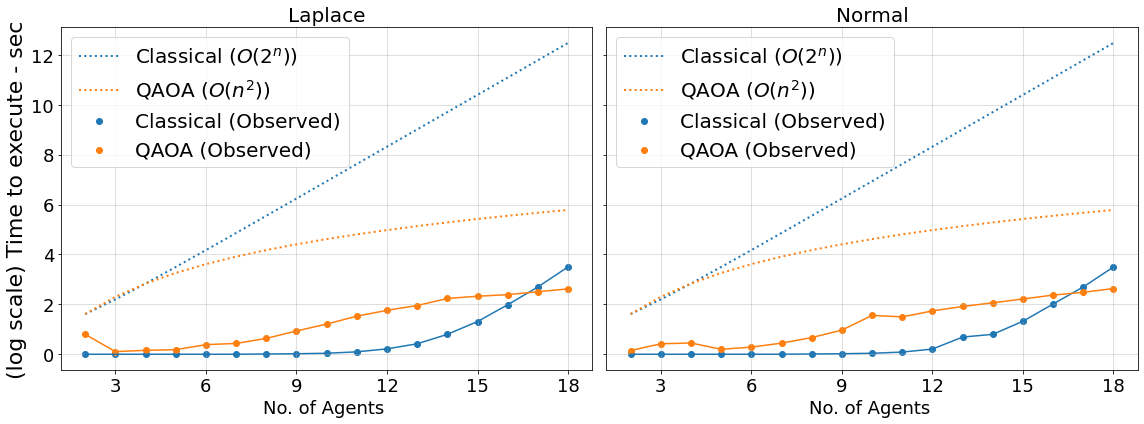

In [201]:
#folder = os.path.join('/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/QAOA_results', str(123))

folder = os.path.join('QAOA_results', str(123))
out_folder= 'Optimal Split Plots'
df=df
log_scale=True
save=True
font=14
labels = [['Brute Force Solution', 'Min-cut brute force solver(Classical)'], ['Qiskit QAOA', 'QAOA (for p=1)']]


fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,6))
fig.set_tight_layout(True)
ax[0].set_ylabel(r"(log scale) Time to execute - sec", fontsize=font+8)
plt.setp(ax, xticks=np.arange(0, 27, 3))#), xticklabels=np.arange(2, 27, 3))


current_folder = os.path.join(folder, out_folder )
create_dir(current_folder)

i=0

for distr in df.Distribution.unique():
    print(distr)
    data = df[df.Distribution == distr]

    n = np.array(list(map(int,data['No. of Agents'])))

    #ax[i].figure(figsize=(8,5))
    x = data['No. of Agents'].to_numpy()

    y_classical = data[(labels[0][0], 'TTE')].astype(float).to_numpy()
    y_classical_theoretical = (2)**(n)

    y_QAOA = data[(labels[1][0], 'TTE')].astype(float).to_numpy()
    y_QAOA_theoretical = (n)**(2)

    if log_scale:
        y_classical = np.log(y_classical+1)
        y_classical_theoretical = np.log(y_classical_theoretical+1)
        y_QAOA = np.log(y_QAOA+1)
        y_QAOA_theoretical = np.log(y_QAOA_theoretical+1)
        file = os.path.join(current_folder, simulator+'_runtimes_log.png')
    else:
        file = os.path.join(current_folder, simulator+'_runtimes.png')
        
    ax[i].scatter(x, y_classical, label="Classical (Observed)")
    ax[i].plot(x, y_classical)
    ax[i].plot(x, y_classical_theoretical,  linestyle = 'dotted', label="Classical ($O(2^n)$)", color='#1f77b4', linewidth=2.0)

    ax[i].scatter(x, y_QAOA, label="QAOA (Observed)")
    ax[i].plot(x, y_QAOA)
    ax[i].plot(x, y_QAOA_theoretical,  linestyle = 'dotted', label="QAOA ($O(n^2)$)", color='#ff7f0e', linewidth=2.0)
    ax[i].tick_params(axis="both", labelsize=font+4)

    ax[i].set_xlabel(r'No. of Agents ',fontdict={'fontsize':font+4})

    ax[i].grid(alpha=.5)
    ax[i].set_title(distr.title(), fontdict={'fontsize':font+6})
    ax[i].legend(fontsize=font+6)
    i+=1
if save:
    print(file)
    plt.savefig(file, dpi=300, bbox_inches = "tight")
plt.show()

## Plot error for gate-based (QAOA) solution of min-cut

In [202]:
bruteforce_values = list(df[('Brute Force Solution','Value')])
qaoa_values = list(df[('Qiskit QAOA','Value')])
gate_based_quality = []

for i, bruteforce_value in enumerate(bruteforce_values):
  if bruteforce_value:
    try:
        gate_based_quality.append(abs((abs(qaoa_values[i]-bruteforce_value)/bruteforce_value)))
    except:
        gate_based_quality.append(abs((abs(qaoa_values[i]-bruteforce_value))))
  else:
    gate_based_quality.append(abs((abs(qaoa_values[i]-bruteforce_value))))

gate_based_quality

df[('Brute Force Solution','Quality')] = [0]*len(bruteforce_values)
df[('Qiskit QAOA','Quality')] = gate_based_quality

laplace
normal



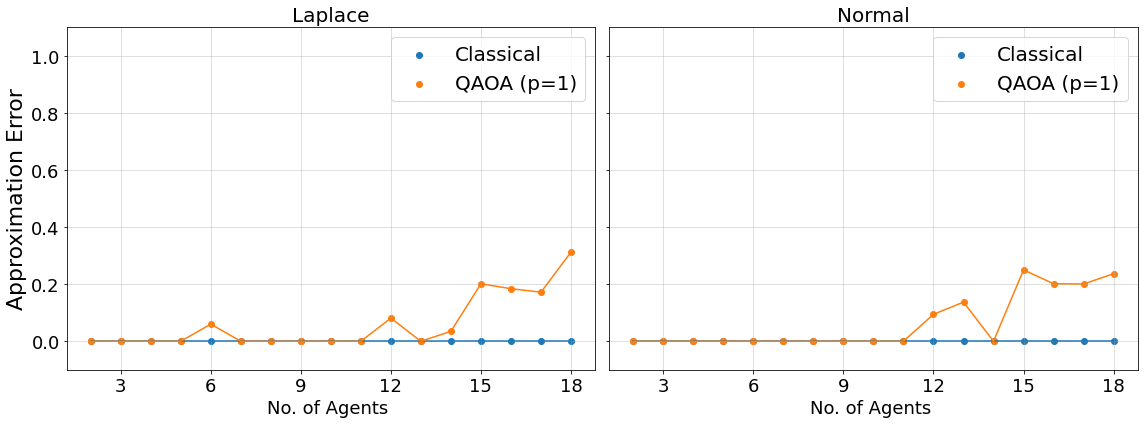

In [204]:
#folder = os.path.join('/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/QAOA_results', str(123))

folder = os.path.join('QAOA_results', str(123))
out_folder= 'Optimal Split Plots'
df=df
save=True
font=14
labels = [['Brute Force Solution', 'Min-cut brute force solver(Classical)'], ['Qiskit QAOA', 'QAOA (for p=1)']]


fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,6))
fig.set_tight_layout(True)
ax[0].set_ylim(-.1, 1.1)
ax[0].set_ylabel(r"Approximation Error", fontsize=font+8)
plt.setp(ax, xticks=np.arange(0, 27, 3))


current_folder = os.path.join(folder, out_folder )
create_dir(current_folder)

i=0

for distr in df.Distribution.unique():
    print(distr)
    data = df[df.Distribution == distr]

    n = np.array(list(map(int,data['No. of Agents'])))

    x = data['No. of Agents'].to_numpy()

    y_classical = data[(labels[0][0], 'Quality')].astype(float).to_numpy()

    y_QAOA = data[(labels[1][0], 'Quality')].astype(float).to_numpy()


    ax[i].scatter(x, y_classical, label="Classical")
    ax[i].plot(x, y_classical)

    ax[i].scatter(x, y_QAOA, label="QAOA (p=1)")
    ax[i].plot(x, y_QAOA)
    ax[i].tick_params(axis="both", labelsize=font+4)

    ax[i].set_xlabel(r'No. of Agents ',fontdict={'fontsize':font+4})

    ax[i].grid(alpha=.5)
    ax[i].set_title(distr.title(), fontdict={'fontsize':font+6})
    ax[i].legend(fontsize=font+6)
    i+=1

file = os.path.join(current_folder, simulator+'_quality.png')
if save:
    print()
    plt.savefig(file, dpi=300, bbox_inches = "tight")
plt.show()

## Testing for probabilities of QAOA output

In [184]:
def solve_qiskit_QAOA(n_agents, induced_subgraph_game, reps = 1, simulator = "aer_simulator_statevector", shots=1000, seed_simulator=123, seed_transpiler=123):
  backend=Aer.get_backend(simulator)
  qins = QuantumInstance(backend=backend, shots=shots, seed_simulator=seed_simulator, seed_transpiler=seed_transpiler)
  G=nx.Graph()
  G.add_nodes_from(np.arange(0,n_agents,1))
  elist = [tuple((int(x)-1 for x in key.split(',')))+tuple([induced_subgraph_game[key]*-1]) for key in induced_subgraph_game]
  G.add_weighted_edges_from(elist)
  w = [[G.get_edge_data(i,j,default = {'weight': 0})['weight']  for j in range(n_agents)] for i in range(n_agents)]
  w = np.array([np.array(row) for row in w])
  max_cut = Maxcut(w)
  qp = max_cut.to_quadratic_program()
  qubitOp, offset = qp.to_ising()
  algorithm_globals.random_seed = seed
  heuristic = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=reps, quantum_instance=qins))
  result = heuristic.solve(qp)
  #print(f"The optimal value found by {result.x}")
  #print(f"the optimal function value {result.fval}")
  #print(f"The result obtained from the underlying algorithm {result.min_eigen_solver_result}")
  #print(f"The x values, the objective function value of the original problem, the probability, and the status of sampling {result.samples}")
  #print(f"The termination status of the optimization algorithm {result.status}")
  #print(f"The x values of the QUBO, the objective function value of the QUBO, and the probability of sampling {result.raw_samples}")
  return result.x, -result.fval, result.samples

In [195]:
simulator = 'aer_simulator'
seed = 123
np.random.seed(seed=seed)
reps = 1
n=6
distribution = laplace
induced_subgraph_game = generate_induced_subgraph_game(distribution,n)

qiskit_qaoa_solution, qiskit_qaoa_value, samples = solve_qiskit_QAOA(n, induced_subgraph_game, reps = reps, simulator = simulator)
qiskit_qaoa_solution, qiskit_qaoa_value, samples

(array([1., 1., 0., 1., 1., 0.]),
 -15.790000000000003,
 [SolutionSample(x=array([1., 1., 0., 1., 1., 0.]), fval=15.790000000000003, probability=0.008, status=<OptimizationResultStatus.SUCCESS: 0>),
  SolutionSample(x=array([0., 0., 1., 0., 0., 1.]), fval=15.79, probability=0.012, status=<OptimizationResultStatus.SUCCESS: 0>),
  SolutionSample(x=array([0., 1., 0., 1., 0., 0.]), fval=12.670000000000002, probability=0.003999999999999999, status=<OptimizationResultStatus.SUCCESS: 0>),
  SolutionSample(x=array([1., 0., 1., 0., 1., 1.]), fval=12.670000000000002, probability=0.011000000000000001, status=<OptimizationResultStatus.SUCCESS: 0>),
  SolutionSample(x=array([1., 0., 0., 0., 0., 1.]), fval=12.600000000000001, probability=0.010000000000000002, status=<OptimizationResultStatus.SUCCESS: 0>),
  SolutionSample(x=array([0., 1., 1., 1., 1., 0.]), fval=12.6, probability=0.015999999999999997, status=<OptimizationResultStatus.SUCCESS: 0>),
  SolutionSample(x=array([0., 1., 1., 1., 0., 0.]), f

In [196]:
bruteforce_solution, bruteforce_value = solve_brute_force(n, induced_subgraph_game)
bruteforce_solution, bruteforce_value

(array([0, 1, 0, 1, 1, 0]), -16.8)

In [197]:
highest_probability = 0
highest_probability_solution, highest_probability_value = 0,0
for sample in samples:
  if sample.probability>highest_probability:
    highest_probability = sample.probability
    highest_probability_solution, highest_probability_value = sample.x, sample.fval

print(f"highest_probability",highest_probability)
print(f"highest_probability_solution, highest_probability_value",highest_probability_solution, highest_probability_value)


best_value = 0
best_value_solution, best_value_value = 0,0
for sample in samples:
  if sample.fval>best_value:
    best_value = sample.fval
    best_value_probability = sample.probability
    best_value_solution, best_value_value = sample.x, sample.fval

print(f"best_value_probability",best_value_probability)
print(f"best_value_solution, best_value_value",best_value_solution, best_value_value)

highest_probability 0.082
highest_probability_solution, highest_probability_value [1. 1. 0. 1. 0. 1.] 0.7300000000000022
best_value_probability 0.008
best_value_solution, best_value_value [1. 1. 0. 1. 1. 0.] 15.790000000000003


In [198]:
bruteforce_solution_probability = np.NaN
bruteforce_solution_solution, bruteforce_solution_value = np.NaN, np.NaN

for sample in samples:
  print(sample.x, bruteforce_solution, (sample.x == bruteforce_solution).all())
  if (sample.x == bruteforce_solution).all():
    bruteforce_solution_probability = sample.probability
    bruteforce_solution_solution, bruteforce_solution_value = sample.x, sample.fval

print(f"bruteforce_solution_probability",bruteforce_solution_probability)
print(f"bruteforce_solution_solution, bruteforce_value_value",bruteforce_solution_solution, bruteforce_solution_value)

[1. 1. 0. 1. 1. 0.] [0 1 0 1 1 0] False
[0. 0. 1. 0. 0. 1.] [0 1 0 1 1 0] False
[0. 1. 0. 1. 0. 0.] [0 1 0 1 1 0] False
[1. 0. 1. 0. 1. 1.] [0 1 0 1 1 0] False
[1. 0. 0. 0. 0. 1.] [0 1 0 1 1 0] False
[0. 1. 1. 1. 1. 0.] [0 1 0 1 1 0] False
[0. 1. 1. 1. 0. 0.] [0 1 0 1 1 0] False
[1. 0. 0. 0. 1. 1.] [0 1 0 1 1 0] False
[1. 1. 0. 1. 0. 0.] [0 1 0 1 1 0] False
[0. 0. 1. 0. 1. 1.] [0 1 0 1 1 0] False
[1. 1. 1. 1. 1. 0.] [0 1 0 1 1 0] False
[0. 0. 0. 0. 0. 1.] [0 1 0 1 1 0] False
[1. 1. 1. 1. 0. 0.] [0 1 0 1 1 0] False
[0. 0. 0. 0. 1. 1.] [0 1 0 1 1 0] False
[1. 1. 0. 1. 1. 1.] [0 1 0 1 1 0] False
[0. 0. 1. 0. 0. 0.] [0 1 0 1 1 0] False
[0. 1. 1. 1. 0. 1.] [0 1 0 1 1 0] False
[1. 0. 0. 0. 1. 0.] [0 1 0 1 1 0] False
[0. 0. 1. 1. 0. 0.] [0 1 0 1 1 0] False
[1. 1. 0. 0. 1. 1.] [0 1 0 1 1 0] False
[1. 1. 1. 1. 0. 1.] [0 1 0 1 1 0] False
[0. 0. 0. 0. 1. 0.] [0 1 0 1 1 0] False
[1. 0. 0. 0. 0. 0.] [0 1 0 1 1 0] False
[0. 1. 1. 1. 1. 1.] [0 1 0 1 1 0] False
[1. 1. 0. 1. 0. 1.] [0 1 0 1 1 0] False


In [199]:
len(samples)

59